# Using STAC Basics
 
In this notebook, we utilise basic functions to explore the SentinelHub Catalog using Pystac.

For running the examples in this Jupyter Notebook you will need to install the pystac-client. To install it from PyPI using pip, use the following command:

In order to access the functionalities of the client API, we should import the pystac_client package along with other necessary packages as follows:

In [7]:
from pystac import Catalog
from pystac import StacIO

from pystac_client import Client
from odc.stac import stac_load, configure_rio
import geopandas as gpd
import folium, shapely
import getpass

The Sentinel Hub API uses OAuth2 Authentication and requires that we have an access token. Thus in python the requests-oauthlib library can handle the retrieval of access tokens using our OAuth Client configuration.

In [8]:
def get_auth():
    # token generation
    from oauthlib.oauth2 import BackendApplicationClient
    from requests_oauthlib import OAuth2Session

    # Your client credentials
    client_id = getpass.getpass("Enter your OAuth Client ID")
    client_secret = getpass.getpass("Enter your OAuth Client Secret")

    # Create a session
    client = BackendApplicationClient(client_id=client_id)
    oauth = OAuth2Session(client=client)

    # Get token for the session
    gen_token = oauth.fetch_token(
        token_url="https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
        client_secret=client_secret,
    )
    return gen_token["access_token"]


token = get_auth()

headers = {"Content-Type": "application/json", "Authorization": f"Bearer {token}"}
url = "https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0"

Enter your OAuth Client ID ········
Enter your OAuth Client Secret ········


In [9]:
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {token}",
}

In [10]:
# Create a PySTAC client and open the catalog
client = Client.open(url, headers=headers)

In [11]:
client

<Client id=sentinel-hub>

In [12]:
# Retrieve the root catalog
root_catalog = client.get_stac_objects(rel=None)
root_catalog

<generator object STACObject.get_stac_objects at 0x7f6363086130>

We can list the collections in a given catalogue using the `client.get_collections` method. This method returns an iterable of PySTAC Collection instances.

In [13]:
collections = list(client.get_collections())

print(f"Number of collections: {len(collections)}")
print("Collections IDs:")
for collection in collections:
    print(f"- {collection.id}")

Number of collections: 6
Collections IDs:
- sentinel-2-l1c
- sentinel-3-olci
- sentinel-3-slstr
- sentinel-1-grd
- sentinel-2-l2a
- sentinel-5p-l2


In [14]:
# Retrieve all catalogs
catalogs = list(client.get_child_links())
catalogs

[<Link rel=child target=https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-2-l1c>,
 <Link rel=child target=https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-3-olci>,
 <Link rel=child target=https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-3-slstr>,
 <Link rel=child target=https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-1-grd>,
 <Link rel=child target=https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-2-l2a>,
 <Link rel=child target=https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-5p-l2>]

Let's grab that collection as a PySTAC Collection instance using the `client.get_child` method so we can look at it in more detail. This method gets a child catalog or collection by ID, so we'll use the collection ID that we printed above.

In [15]:
collection = client.get_child("sentinel-2-l1c")
if collection is None:
    print("Collection is Empty. Check your downloads and try agian.")
else:
    print("Collection has a root child. You may proceed.")

Collection has a root child. You may proceed.


In [16]:
bbox = [84.5, 26.5, 86.501, 26.501]

# Set a start and end date
time = "2020-12-10", "2021-02-01"

# Set the STAC collections
collections = ["sentinel-2-l1c"]

In [17]:
collection

<CollectionClient id=sentinel-2-l1c>

In [18]:
query = client.search(bbox=bbox, collections=collections, datetime=time)

# Search the STAC catalog for all items matching the query
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 113 datasets


In [19]:
stac_json = query.get_all_items_as_dict()

Now, we'll use GeoPandas DataFrame object to make plotting easier.

In [20]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
gdf.head()

,geometry,datetime,platform,instruments,constellation,gsd,eo:cloud_cover,proj:epsg,proj:bbox,proj:geometry
0,"MULTIPOLYGON (((85.09657 26.11852, 84.85992 26...",2021-02-01T05:01:27.515Z,sentinel-2b,[msi],sentinel-2,10,99.80,32645,"[199980.0, 2890200.0, 309780.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."
1,"MULTIPOLYGON (((85.08217 27.04617, 84.85432 26...",2021-02-01T05:01:27Z,sentinel-2b,[msi],sentinel-2,10,99.93,32645,"[199980.0, 2890200.0, 309780.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."
2,"MULTIPOLYGON (((85.10272 27.10965, 86.08991 27...",2021-02-01T05:01:22.151Z,sentinel-2b,[msi],sentinel-2,10,57.60,32645,"[300000.0, 2890200.0, 409800.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."
3,"MULTIPOLYGON (((85.09788 27.10958, 84.99021 26...",2021-02-01T05:01:22Z,sentinel-2b,[msi],sentinel-2,10,61.04,32645,"[300000.0, 2890200.0, 409800.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."
4,"MULTIPOLYGON (((85.99066 27.11883, 87.09847 27...",2021-02-01T05:01:18.806Z,sentinel-2b,[msi],sentinel-2,10,3.74,32645,"[399960.0, 2890200.0, 509760.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."


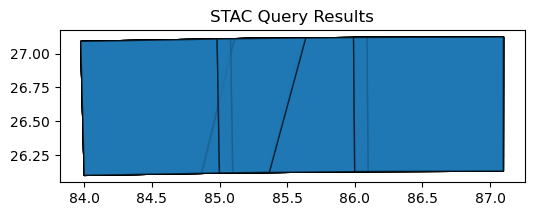

In [21]:
fig = gdf.plot(
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

Finally, let's plot STAC Items on a Map

In [22]:
# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure
from odc.stac import configure_rio, stac_load


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))


fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    categorical=False,
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

In [ ]:
from pystac_client import Client
import geopandas as gpd
import requests
from creds import *


# Code from CDSE
def get_keycloak(username: str, password: str) -> str:
data = {
"client_id": "cdse-public",
"username": username,
"password": password,
"grant_type": "password",
}
try:
r = requests.post("https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
data=data,
)
r.raise_for_status()
exceptExceptionase:
raiseException(
f"Keycloak token creation failed. Reponse from the server was: {r.json()}"
)
returnr.json()["access_token"]

# Get AOI geometry
AOI = gpd.read_file('<PATH TO AOI FILE>.geojson')['geometry'][0]

# Format date range string
DATES = "2020-01-01/2020-06-29"

# Retrieve token from CDSE function
TOKEN = get_keycloak(<EMAIL>, <PASSWORD>)

# Instantiate the client with STAC API endpoint
ENDPOINT = Client.open('https://catalogue.dataspace.copernicus.eu/stac',
headers={"Authorization":f"Bearer {TOKEN}"})

# Perform a search
search = ENDPOINT.search(
collections=['SENTINEL-3'],
datetime=DATES,
intersects=AOI,
)

# Get items (Here is where I get the error get the error)
itemResults = search.get_all_items()